# Data Restructuring

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
source_dir = r'C:\Users\13472\Documents\Flatiron\Land cover\train'
target_dir = r'C:\Users\13472\Documents\Flatiron\Land cover\Data'

# Create target directories if they don't exist
for directory in ['train_images', 'train_masks']:
    os.makedirs(os.path.join(target_dir, directory, 'train'), exist_ok=True)
    
for directory in ['val_images', 'val_masks']:
    os.makedirs(os.path.join(target_dir, directory, 'val'), exist_ok=True)
    
# Split data into train and validation sets
images = [f for f in os.listdir(source_dir) if f.endswith('_sat.jpg')]
masks = [f for f in os.listdir(source_dir) if f.endswith('_mask.png')]

images_train, images_val, masks_train, masks_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Function to move files
def copy_files(file_list, source, target):
    for file in file_list:
        source_path = os.path.join(source, file)
        target_path = os.path.join(target, file)
        shutil.copy(source_path, target_path)

# Move train images and masks
copy_files(images_train, source_dir, os.path.join(target_dir, 'train_images', 'train'))
copy_files(masks_train, source_dir, os.path.join(target_dir, 'train_masks', 'train'))

# Move validation images and masks
copy_files(images_val, source_dir, os.path.join(target_dir, 'val_images', 'val'))
copy_files(masks_val, source_dir, os.path.join(target_dir, 'val_masks', 'val'))

print("Data restructuring completed.")


Data restructuring completed.


# Mask transformation from 3 dimetional to 1 dimetion

In [21]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [22]:
seed=24
batch_size= 2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = {
    'rescale': 1/255.,        # Original pixel values are 0 and 255. Rescale to 0 to 1.
    'rotation_range': 90,
    'width_shift_range': 0.3,
    'height_shift_range': 0.3,
    'shear_range': 0.5,
    'zoom_range': 0.3,
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'reflect',
    'preprocessing_function': lambda x: (x / 255.).astype('float32')  # Normalize pixel values to range [0, 1]
}


In [25]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

train_image_generator = image_data_generator.flow_from_directory(
    "Data/train_images/",
    target_size=(2448, 2448),
    batch_size=1,
    class_mode=None,  # No labels, only images
    seed=42
)

train_mask_generator = mask_data_generator.flow_from_directory(
    "Data/train_masks/",
    target_size=(2448, 2448),
    batch_size=1,
    class_mode=None,  # No labels, only masks
    seed=42
)

val_image_generator = image_data_generator.flow_from_directory(
    "Data/val_images/",
    target_size=(2448, 2448),
    batch_size=1,
    class_mode=None,  # No labels, only images
    seed=42
)

val_mask_generator = mask_data_generator.flow_from_directory(
    "Data/val_masks/",
    target_size=(2448, 2448),
    batch_size=1,
    class_mode=None,  # No labels, only masks
    seed=42
)


Found 642 images belonging to 1 classes.
Found 642 images belonging to 1 classes.
Found 161 images belonging to 1 classes.
Found 161 images belonging to 1 classes.


In [26]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

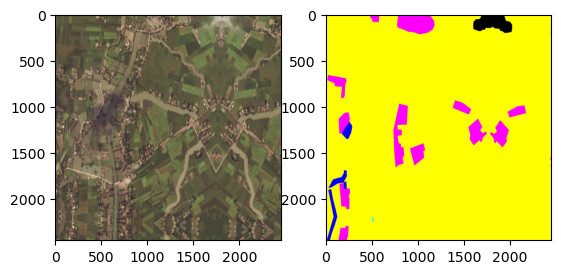

In [33]:
def inverse_normalize(mask):
    """
    Inverse normalization for masks.
    """
    return mask * 255.0

x = train_image_generator.next()
y = train_mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    unnormalized_mask = inverse_normalize(mask)
    plt.imshow(unnormalized_mask, cmap='gray')
    plt.show()

In [12]:
from unet_model_with_functions_of_blocks import multi_unet_model

In [13]:
from keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

In [14]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [16]:
model = multi_unet_model()

In [18]:
from unet_model_with_functions_of_blocks import jacard_coef  

model.summary()

num_train_imgs = len(os.listdir('Data - Copy/train/images/'))

steps_per_epoch = num_train_imgs //batch_size

metrics=['accuracy', jacard_coef]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=50)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2448, 2448,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 2448, 2448,   448         ['input_2[0][0]']                
                                16)                                                               
                                                                                                  
 dropout_9 (Dropout)            (None, 2448, 2448,   0           ['conv2d_19[0][0]']              
                                16)                                                           

                                                                                                  
 conv2d_31 (Conv2D)             (None, 612, 612, 64  73792       ['concatenate_5[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_15 (Dropout)           (None, 612, 612, 64  0           ['conv2d_31[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 612, 612, 64  36928       ['dropout_15[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_tr

C:\Users\13472\AppData\Local\Temp\ipykernel_13252\2842001893.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=val_generator,


Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\13472\AppData\Local\Temp\ipykernel_13252\2842001893.py", line 13, in <module>
      history = model.fit_generator(train_generator, validation_data=val_generator,
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\13472\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[5992704,7] labels_size=[5992704,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_3969]